# Donut Fine-tuning

El presente notebook es el proceso de fine-tuning para [DoNut-base](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://huggingface.co/naver-clova-ix/donut-base-finetuned-cord-v2&ved=2ahUKEwjMh4O54vGNAxVsIrkGHQznKskQFnoECBcQAQ&usg=AOvVaw1uKtlO2jgCL6oC_haM4FIB).

In [16]:
pip install datasets transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [17]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
#from transformers import MobileViTForImageClassification, MobileViTImageProcessor
from transformers import ViTForImageClassification, ViTImageProcessor, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device) # Expected: ‘cuda’ if Linux else ‘mps’ if MacOS
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

cuda


In [4]:
import transformers

print(torch.__version__)
print(transformers.__version__)

2.6.0+cu126
4.52.4


# Descargando modelos

In [6]:
from dotenv import load_dotenv
import os

# Try different .env paths
env_path = os.path.join("..","vpc3_proyecto",".env")
# env path using os path join
    
print(f"🔍 Trying .env path: {env_path}")

# Load environment variables
found = load_dotenv(env_path)
print(f"✅ .env file {'found' if found else 'not found'}")

# Verify loaded variables
print("\n🔎 Environment variables:")
for var in ["PROCESSED_DATA_DIR", "RAW_DATA_DIR", "CHECKPOINT_DIR"]:
    value = os.getenv(var)
    print(f"{var}: {'✅' if value else '❌'} {value}")

img_dir_train = os.path.join(os.getenv("PROCESSED_DATA_DIR"),'train2014')
img_dir_val = os.path.join(os.getenv("PROCESSED_DATA_DIR"),'val2014')
img_dir_test =  os.path.join(os.getenv("PROCESSED_DATA_DIR"),'test2014')
ann_coco_text = os.path.join(os.getenv("RAW_DATA_DIR"),'cocotext.v2.zip')

print(ann_coco_text)

🔍 Trying .env path: ../vpc3_proyecto/.env
✅ .env file found

🔎 Environment variables:
PROCESSED_DATA_DIR: ✅ /home/juan/CEIA/vpc3-proyecto/vpc3_proyecto/data/processed
RAW_DATA_DIR: ✅ /home/juan/CEIA/CEIA-ViT/TrabajosPracticos/TP_Final/data/raw
CHECKPOINT_DIR: ✅ /home/juan/CEIA/vpc3-proyecto/vpc3_proyecto/models
/home/juan/CEIA/CEIA-ViT/TrabajosPracticos/TP_Final/data/raw/cocotext.v2.zip


In [7]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

# 1. First fix the model configuration
model.config.decoder_start_token_id = processor.tokenizer.pad_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

In [8]:

from vpc3_proyecto.model_training.dataset_donut_model import DonutTextDatasetFromCocoTextV2Raw

train_dataset = DonutTextDatasetFromCocoTextV2Raw(img_dir_train, ann_coco_text, processor=processor)
val_dataset = DonutTextDatasetFromCocoTextV2Raw(img_dir_val, ann_coco_text, processor=processor)
test_dataset = DonutTextDatasetFromCocoTextV2Raw(img_dir_test, ann_coco_text, processor=processor)


In [9]:
val_dataset.__len__()


4697

In [10]:
train_dataset.__len__()

16440

In [11]:
test_dataset.__len__()

2348

### Inferencia con modelo preentrenado (sin finetuning)

#### Ejemplo: Imagen y texto originales 

In [12]:
sample = train_dataset[0]

In [13]:
from PIL import Image

first_text = processor.tokenizer.decode(sample["labels"][sample["labels"] != -100])  # Decode the text labels

# If you want to see the actual PIL image before processing:
original_image = Image.open(sample["img_path"]).convert("RGB")

# Display results
print("Ground truth Text:", first_text)
original_image.show()  # This will display the original image

Ground truth Text: <s> 35 LIMIT SPEED</s>


#### Probamos inferir con el modelo tal cual viene (misma imagen)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


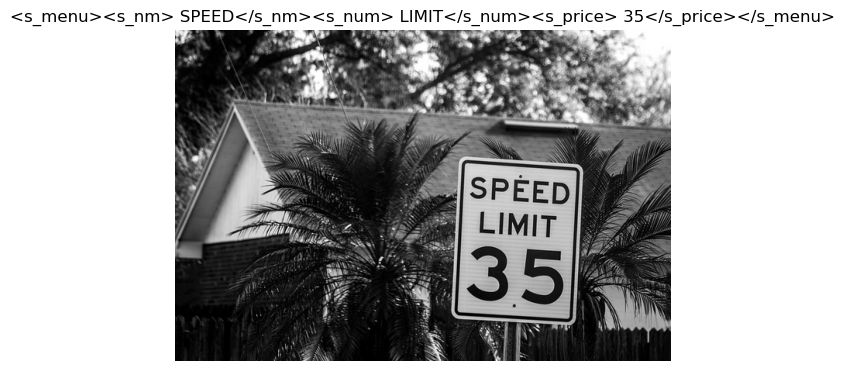

Texto detectado: <s_menu><s_nm> SPEED</s_nm><s_num> LIMIT</s_num><s_price> 35</s_price></s_menu>


In [14]:
from vpc3_proyecto.visualization.infer_from_image import infer_text_from_image
task_prompt = "<s_cord-v2>"

result_text = infer_text_from_image(original_image, model, processor,task_prompt=task_prompt)
print("Texto detectado:", result_text)

El texto es bien detectado, pero vemos que el modelo agrega tokens / tagas al inicio y final del texto detectado, como si se tratara de una tabla / lista de precios.

#### Probamos evaluar el modelo con el dataset de test 

In [18]:



from vpc3_proyecto.model_evaluation.utils import manual_evaluate

model.eval()  # Set to evaluation mode
torch.cuda.empty_cache()

metrics = manual_evaluate(
    model=model,
    dataset=test_dataset,
    processor=processor,
    max_samples=None  # Start small, then increase if successful
)
print(metrics)

  0%|          | 7/2348 [00:12<1:09:20,  1.78s/it]


KeyboardInterrupt: 

# Entrenamiento (fine tuning)

In [19]:
import os
os.environ["WANDB_DISABLED"] = "true" # no utilizamos weights and biases

In [20]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir=os.path.join(os.getenv("CHECKPOINT_DIR"),"donut-finetuned-coco2014"),
    per_device_train_batch_size=1,  # Minimum possible
    gradient_accumulation_steps=1,  # No accumulation
    fp16=True,                      # Mixed precision
    gradient_checkpointing=True,    # Memory optimization
    optim="adamw_8bit",             # 8-bit optimizer
    eval_strategy="no",
    per_device_eval_batch_size=1,
    save_strategy="epoch",             # Disable checkpoints
    logging_steps=50,
    learning_rate=1e-5,
    num_train_epochs=1              # Start with 1 epoch
)





Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [22]:
from vpc3_proyecto.model_evaluation.utils import compute_metrics
from functools import partial
from transformers import Seq2SeqTrainer 
compute_metrics_bound = partial(compute_metrics, donut_processor=processor)
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_bound,
)


In [23]:
torch.cuda.empty_cache() # limpiamos cache

trainer.train()
# trainer.train(resume_from_checkpoint=True)  # Automatically finds latest checkpoint

`use_cache=True` is incompatible with gradient checkpointing`. Setting `use_cache=False`...
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
50,4.554900


KeyboardInterrupt: 

In [24]:

from vpc3_proyecto.model_evaluation.utils import get_last_checkpoint_folder

last_ckpt = get_last_checkpoint_folder(training_args.output_dir)

manually_saved_folder = os.path.join(last_ckpt, "manually-saved")

if last_ckpt:
    print(f"✅ Último checkpoint: {last_ckpt}")
    processor.save_pretrained(manually_saved_folder)
    trainer.save_model(manually_saved_folder)
    print("✅ Processor guardado en el directorio manual save dentro del checkpoint: "+manually_saved_folder)
else:
    print("❌ No se encontraron checkpoints")



✅ Último checkpoint: ./donut-finetuned-coco2014/checkpoint-15656
✅ Processor guardado en el directorio manual save dentro del checkpoint: ./donut-finetuned-coco2014/checkpoint-15656/manually-saved


# Evaluamos modelo finetuneado  para ver si mejoro alguna metrica

In [28]:
import torch
import glob
from transformers import VisionEncoderDecoderModel, DonutProcessor

torch.cuda.empty_cache()
last_ckpt = get_last_checkpoint_folder(training_args.output_dir)
manually_saved_folder = os.path.join(last_ckpt, "manually-saved")


processor = DonutProcessor.from_pretrained(manually_saved_folder)

model = VisionEncoderDecoderModel.from_pretrained(
    manually_saved_folder,
    device_map="auto",
    torch_dtype=torch.float16  
)


test_dataset = DonutTextDatasetFromCocoTextV2Raw(
    img_dir_test,  
    ann_coco_text,
    processor=processor,
    max_length=512
)
model.config.decoder_start_token_id = processor.tokenizer.pad_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id


In [27]:
print(f"Model device: {model.device}")
print(f"Vocab size: {model.config}")

Model device: cuda:0
Vocab size: VisionEncoderDecoderConfig {
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "activation_dropout": 0.0,
    "activation_function": "gelu",
    "add_cross_attention": true,
    "add_final_layer_norm": true,
    "attention_dropout": 0.0,
    "classifier_dropout": 0.0,
    "d_model": 1024,
    "decoder_attention_heads": 16,
    "decoder_ffn_dim": 4096,
    "decoder_layerdrop": 0.0,
    "decoder_layers": 4,
    "dropout": 0.1,
    "encoder_attention_heads": 16,
    "encoder_ffn_dim": 4096,
    "encoder_layerdrop": 0.0,
    "encoder_layers": 12,
    "init_std": 0.02,
    "is_decoder": true,
    "is_encoder_decoder": false,
    "max_position_embeddings": 768,
    "model_type": "mbart",
    "num_hidden_layers": 12,
    "scale_embedding": true,
    "torch_dtype": "float16",
    "use_cache": true,
    "vocab_size": 57580
  },
  "decoder_start_token_id": 1,
  "encoder": {
    "attention_probs_dropout_prob": 0.0,
    "depths": [
      

In [29]:
metrics = manual_evaluate(
    model=model,
    dataset=test_dataset,
    processor=processor,
    max_samples=None  ,
    results_save_path=manually_saved_folder
)

  1%|          | 14/2348 [00:03<09:18,  4.18it/s]


KeyboardInterrupt: 

In [ ]:
model